In [1]:
import numpy as np
import Uncertainty as unc
import UncertaintyM as uncM
import Data.data_provider as dp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
seed = 10

# Loading data

In [2]:
x_train, y_train, x_test, y_test, x_test_ood, y_test_ood, x_test_idoodmix, y_test_idoodmix, x_valid, y_valid = dp.load_ood("fashionMnist", seed=seed)

# train normal model

In [3]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=seed)
model.fit(x_train, y_train)
predictions_x_test = model.predict(x_test)
print("model test score = ", model.score(x_test, y_test))

model test score =  0.9053333333333333


# train calibrated model

In [4]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

model_calib = CalibratedClassifierCV(model, cv=5, method="isotonic")
model_calib.fit(x_train, y_train)
print("model test score = ", model_calib.score(x_test, y_test))

model test score =  0.9123809523809524


# quantify uncertainty

In [5]:
tu, eu, au = unc.model_uncertainty(model, x_test, x_train, y_train)
tumc, eumc, aumc = unc.calib_ens_member_uncertainty(model, x_test, x_train, y_train, x_valid, y_valid, calib_method="isotonic")
tuc = unc.calib_ens_total_uncertainty(model_calib, x_test)


# plot acc-rej cuves

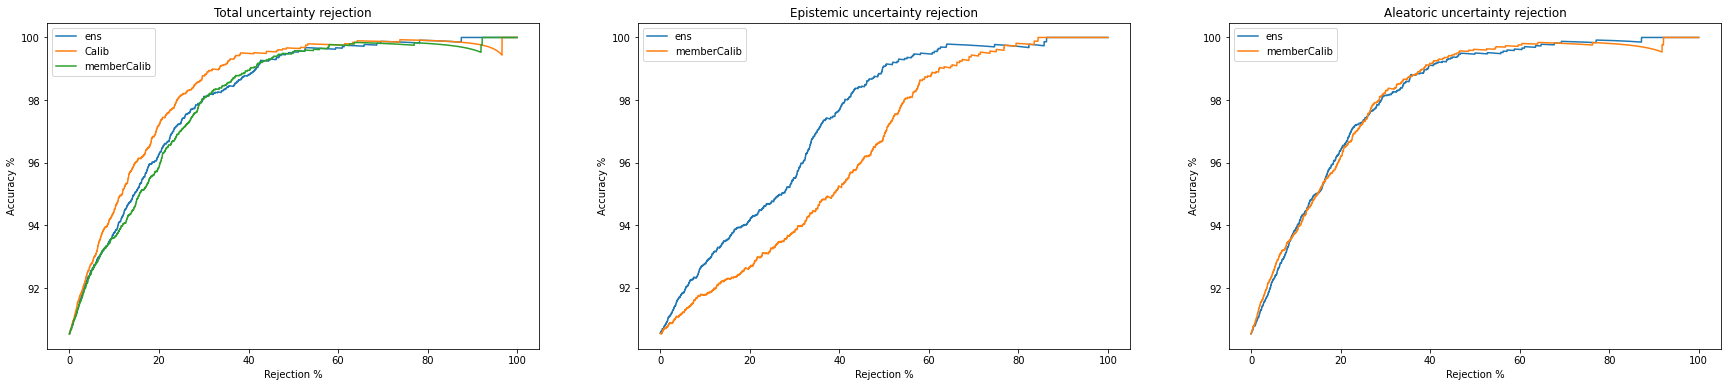

In [6]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(3*2)
fig.set_figwidth(15*2)

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), tu.reshape((1,-1)))
avg_acc_c, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), tuc.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), tumc.reshape((1,-1)))
axs[0].plot(steps, avg_acc*100, label='ens')
axs[0].plot(steps, avg_acc_c*100, label='Calib')
axs[0].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[0].legend()
axs[0].set_title("Total uncertainty rejection")

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), eu.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), eumc.reshape((1,-1)))

axs[1].plot(steps, avg_acc*100,label='ens')
axs[1].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[1].set_title("Epistemic uncertainty rejection")
axs[1].legend()

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), au.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions_x_test.reshape((1,-1)), y_test.reshape((1,-1)), aumc.reshape((1,-1)))

axs[2].plot(steps, avg_acc*100, label='ens')
axs[2].plot(steps, avg_acc_mc*100, label='memberCalib')
axs[2].set_title("Aleatoric uncertainty rejection")
axs[2].legend()

for i in range(3):
    axs[i].set(xlabel="Rejection %", ylabel="Accuracy %")

fig.show()

# out of distribution Epistemic test

In [7]:
# quantify uncertainty for OOD data
tu_ood, eu_ood, au_ood = unc.model_uncertainty(model, x_test_idoodmix, x_train, y_train)
tumc_ood, eumc_ood, aumc_ood = unc.calib_ens_member_uncertainty(model, x_test_idoodmix, x_train, y_train, x_valid, y_valid)
tuc_ood = unc.calib_ens_total_uncertainty(model_calib, x_test_idoodmix)

In [8]:
from sklearn.metrics import roc_auc_score
print("Ens")
print(f"{roc_auc_score(y_test_idoodmix, tu_ood)* 100:.2f} Total uncertainty") 
print(f"{roc_auc_score(y_test_idoodmix, eu_ood)* 100:.2f} Epist uncertainty") 
print(f"{roc_auc_score(y_test_idoodmix, au_ood)* 100:.2f} Aleat uncertainty") 
print("EnsMemberCalib")
print(f"{roc_auc_score(y_test_idoodmix, tumc_ood)* 100:.2f} Total uncertainty") 
print(f"{roc_auc_score(y_test_idoodmix, eumc_ood)* 100:.2f} Epist uncertainty") 
print(f"{roc_auc_score(y_test_idoodmix, aumc_ood)* 100:.2f} Aleat uncertainty") 
print("EnsCalib")
print(f"{roc_auc_score(y_test_idoodmix, tuc_ood)* 100:.2f} Total uncertainty") 


Ens
52.01 Total uncertainty
55.98 Epist uncertainty
50.67 Aleat uncertainty
EnsMemberCalib
54.00 Total uncertainty
58.04 Epist uncertainty
53.47 Aleat uncertainty
EnsCalib
49.90 Total uncertainty
